In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap

/home/drosophila-lab/Documents/Genomics Project/snp-data/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
print('Before loading data.')
df = pd.read_csv("/home/drosophila-lab/Documents/Genomics Project/snp-data/SNP_CSV.csv")
print('Finished loading data.')

Before loading data.
Finished loading data.


In [3]:
# Step 1: Add Trajectory labeling
# CACO', 'CAO', 'NACO', 'ANCO
def assign_trajectory(pop_value):
    if pop_value.startswith("A") or pop_value.startswith("NA"):
        return "A trajectory"
    elif pop_value.startswith("C"):
        return "C trajectory"
    else:
        return "Unknown"

df['Trajectory'] = df['Pop'].apply(assign_trajectory)

In [4]:
# Feature engineering - create trajectory features
freq_cols = ['Freq1', 'Freq2', 'Freq3', 'Freq4']
X = df[freq_cols].values

print("here1")

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality Reduction with PCA (first reduce to 50 components for UMAP)
n_components = min(X.shape[0], X.shape[1])
print("Running initial PCA for memory optimization...")
pca_pre = PCA(n_components=n_components, svd_solver='covariance_eigh')  # Reduces memory footprint
X_pca_pre = pca_pre.fit_transform(X_scaled)

# UMAP Dimensionality Reduction (optimized for large datasets)
print("Starting UMAP...")
reducer = umap.UMAP(
    n_neighbors=15,  # Reduced from default 15 to 10 for large datasets
    min_dist=0.1,    # Increased from 0.1 to 0.3 for speed
    metric='euclidean',  # Faster than default cosine
    low_memory=True,  # Critical for large datasets
    n_epochs=200,     # Reduced from default 500 (trade accuracy for speed)
    verbose=True      # Show progress
)

subset_size = 50000  # Adjust based on your RAM and needs
if len(X_scaled) > subset_size:
    np.random.seed(42)
    sample_idx = np.random.choice(len(X_scaled), subset_size, replace=False)
    X_umap = X_scaled[sample_idx]
    df_umap = df.iloc[sample_idx]
else:
    X_umap = X_scaled
    df_umap = df

X_pca = pca_pre.fit_transform(X_umap)
embedding = reducer.fit_transform(X_umap)

# embedding = reducer.fit_transform(X_pca_pre)  # Use PCA-reduced data
print("here3")

here1
Running initial PCA for memory optimization...
Starting UMAP...


/home/drosophila-lab/Documents/Genomics Project/snp-data/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP(n_epochs=200, verbose=True)
Fri May 30 12:35:47 2025 Construct fuzzy simplicial set
Fri May 30 12:35:47 2025 Finding Nearest Neighbors
Fri May 30 12:35:47 2025 Building RP forest with 16 trees
Fri May 30 12:35:50 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Fri May 30 12:35:54 2025 Finished Nearest Neighbor Search
Fri May 30 12:35:55 2025 Construct embedding


Epochs completed:  12%| █▎         25/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs


Epochs completed:  39%| ███▉       78/200 [00:01]

	completed  60  /  200 epochs
	completed  80  /  200 epochs


Epochs completed:  63%| ██████▎    126/200 [00:01]

	completed  100  /  200 epochs
	completed  120  /  200 epochs


Epochs completed:  80%| ███████▉   159/200 [00:01]

	completed  140  /  200 epochs
	completed  160  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [00:01]

	completed  180  /  200 epochs
Fri May 30 12:36:13 2025 Finished embedding
here3


In [5]:
# Clustering with K-Means (can be adjusted as needed)
kmeans = KMeans(n_clusters=1, random_state=42)  # Assuming single population (CACO)
df['Cluster'] = kmeans.fit_predict(X_scaled)
print("here4")

here4


here5


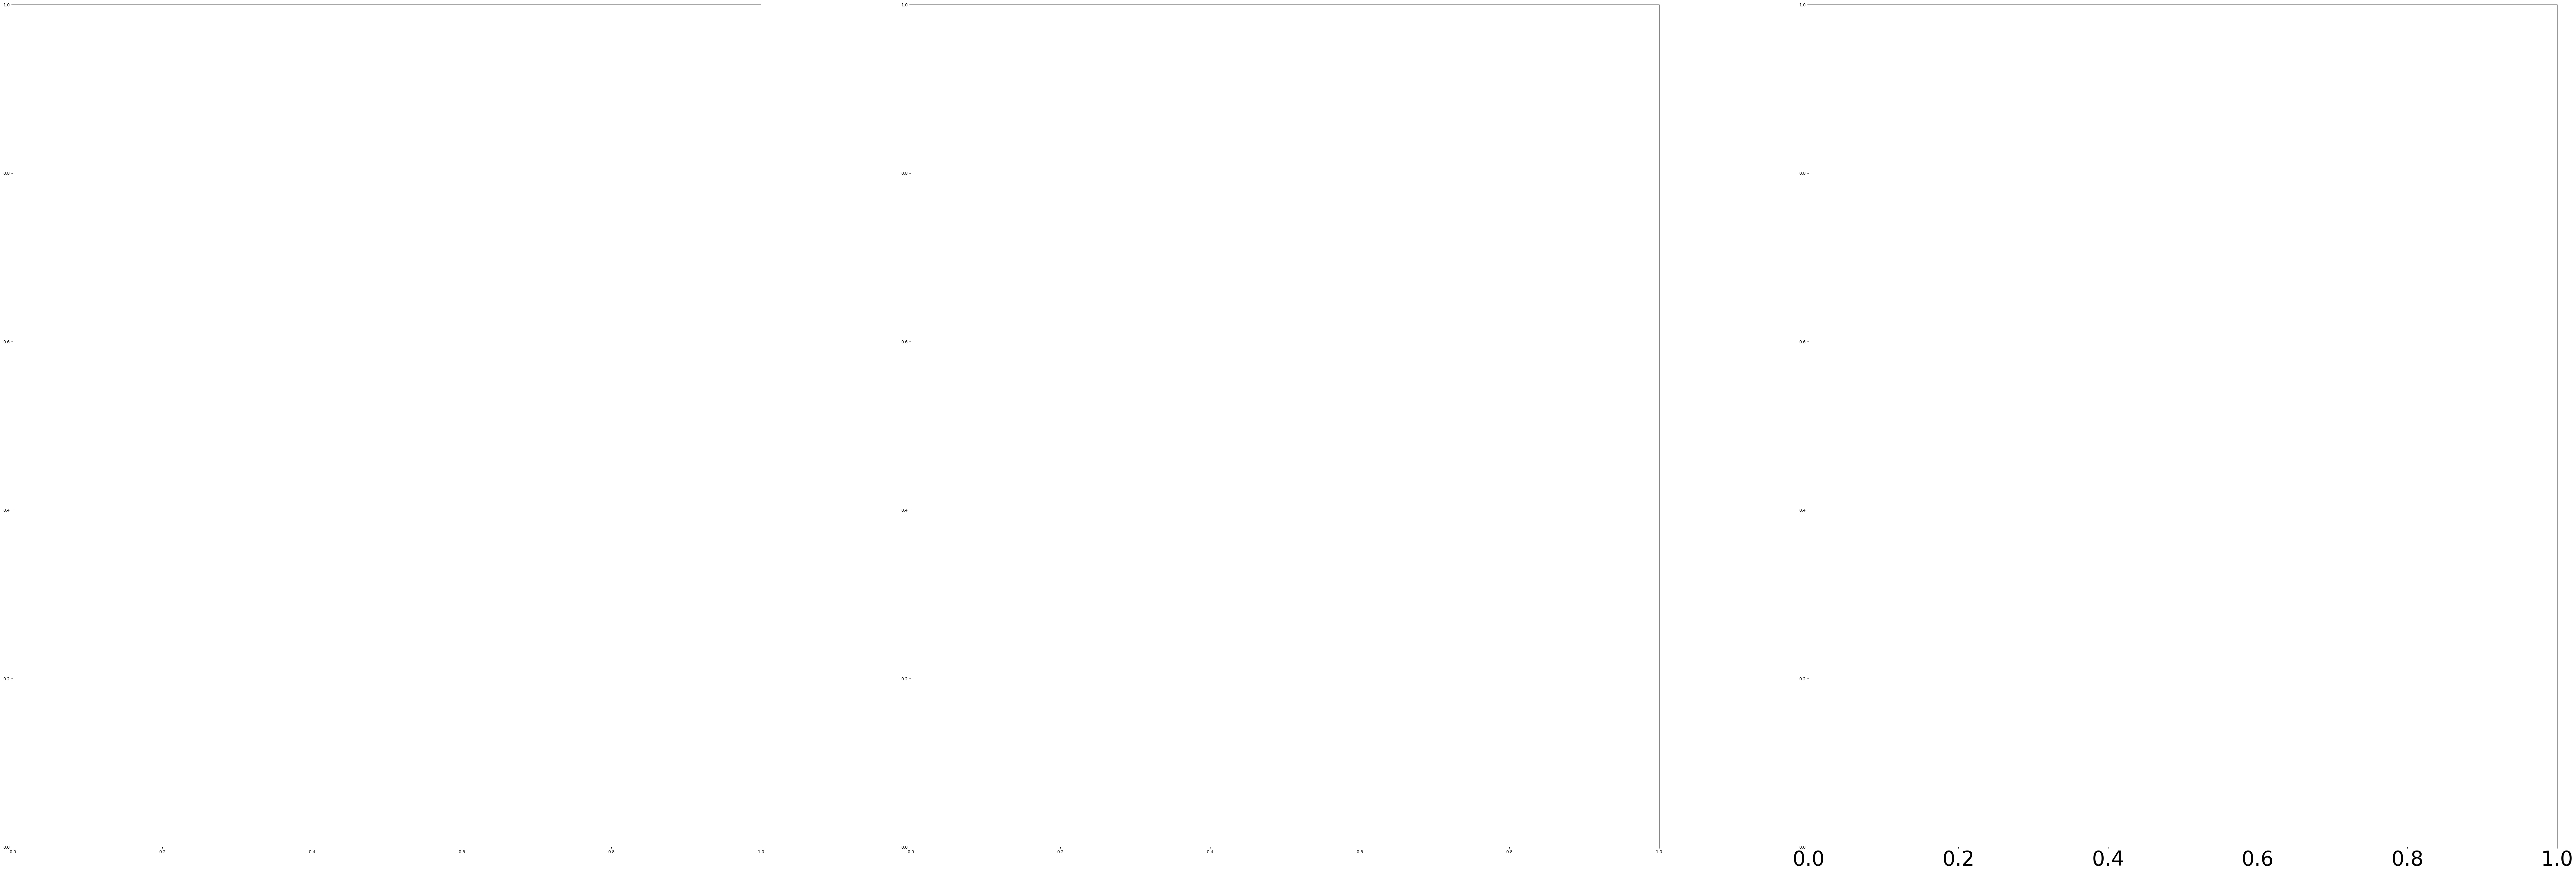

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(108, 36))

print("here5")

In [36]:
# PCA Plot colored by Trajectory
# X_pca = pca_pre.fit_transform(X_umap)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_umap['Trajectory'], ax=axes[0])
axes[0].set_title('PCA Projection by Trajectory', fontsize=48)

print(f"PCA range X: {X_pca[:, 0].min():.3f} to {X_pca[:, 0].max():.3f}")
print(f"PCA range Y: {X_pca[:, 1].min():.3f} to {X_pca[:, 1].max():.3f}")

axes[0].set_xlim(X_pca[:, 0].min()-0.1, X_pca[:, 0].max()+0.1)
axes[0].set_ylim(X_pca[:, 1].min()-0.1, X_pca[:, 1].max()+0.1)

# axes[0].plot()

PCA range X: -6.595 to 1.801
PCA range Y: -3.740 to 2.587


(-3.840208758707102, 2.687463889795577)

In [37]:
# UMAP Plot colored by Trajectory
trajectory_colors = {"A trajectory": "blue", "C trajectory": "red", "Unknown": "gray"}

print(f"UMAP range X: {embedding[:, 0].min():.3f} to {embedding[:, 0].max():.3f}")
print(f"UMAP range Y: {embedding[:, 1].min():.3f} to {embedding[:, 1].max():.3f}")

axes[1].scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=df_umap['Trajectory'].map(trajectory_colors),
    label=df_umap['Trajectory']
)
axes[0].set_xlim(embedding[:, 0].min()-0.1, embedding[:, 0].max()+0.1)
axes[0].set_ylim(embedding[:, 1].min()-0.1, embedding[:, 1].max()+0.1)
axes[1].set_title('UMAP Projection by Trajectory', fontsize=48)

UMAP range X: -7.704 to 25.820
UMAP range Y: -15.135 to 20.401


Text(0.5, 1.0, 'UMAP Projection by Trajectory')

In [46]:
# Frequency Trajectory Plot (VISUAL)

for i, row in df_umap.iloc[:50].iterrows():
    axes[2].plot(freq_cols, row[freq_cols], label=f"Sample {i+1} ({row['Trajectory']})",
                 color=trajectory_colors.get(row['Trajectory'], "gray"), alpha=0.5)
axes[2].set_title('Frequency Trajectories', fontsize=48)
axes[2].set_ylabel('Frequency', fontsize=48)
axes[2].legend(fontsize='small', loc='upper left', bbox_to_anchor=(1, 1))

fig.tight_layout()
fig.savefig("clustervis3.png")
print("here6")

/tmp/ipykernel_713415/1016700190.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


here6


In [10]:
# Prediction function for new data (for inference)
def predict_population(new_frequencies):
    new_data = scaler.transform([new_frequencies])
    cluster = kmeans.predict(new_data)[0]
    return f"Cluster {cluster}"

# Example usage
new_sample = [0.85, 0.90, 0.91, 0.92]
print(f"Predicted cluster: {predict_population(new_sample)}")

Predicted cluster: Cluster 0
